## Part II: Machine Learning and Business Use Case
Now we have a basic understanding of why customers returned orders. Next, we want to use machine learning to predict which orders are most likely to be returned. In this part, we will generate several features based on our previous findings and our customer's requirements.

In [65]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay,\
roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split

# option to display all dataframe columns
pd.options.display.max_columns = None

# Update rcParams in mpl
rcParams = {
        'font.size': 20,                # all fonts-size in plot
        'font.weight': 'bold',          # bold all fonts
        'figure.titleweight': 'bold',   # bold supertitle
        'axes.linewidth' : 6,
        'xtick.major.width': 6,
        'axes.spines.top': True,
        'axes.spines.right': True,
        'lines.linewidth': 6,
        'legend.fontsize': 'large',
        'xtick.labelsize': 'large',
        'ytick.labelsize': 'large',
        'xtick.labelsize': 20,   # sets x-tick font size
        'ytick.labelsize': 20,
        'axes.titlepad': 20,   # spacing between suptitle and figure
        'axes.facecolor': 'white'
    }

#### Read raw data

In [66]:
# read the csv file into dataframe
raw_orders = pd.read_csv('./../data/raw/Orders.csv')
raw_returns = pd.read_csv('./../data/raw/Returns.csv')

#### Check Raw Data

In [43]:
raw_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Row.ID          51290 non-null  int64  
 1   Order.ID        51290 non-null  object 
 2   Order.Date      51290 non-null  object 
 3   Ship.Date       51290 non-null  object 
 4   Ship.Mode       51290 non-null  object 
 5   Customer.ID     51290 non-null  object 
 6   Customer.Name   51290 non-null  object 
 7   Segment         51290 non-null  object 
 8   Postal.Code     9994 non-null   float64
 9   City            51290 non-null  object 
 10  State           51290 non-null  object 
 11  Country         51290 non-null  object 
 12  Region          51290 non-null  object 
 13  Market          51290 non-null  object 
 14  Product.ID      51290 non-null  object 
 15  Category        51290 non-null  object 
 16  Sub.Category    51290 non-null  object 
 17  Product.Name    51290 non-null 

In [44]:
raw_returns.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Returned  1079 non-null   object
 1   Order ID  1079 non-null   object
 2   Region    1079 non-null   object
dtypes: object(3)
memory usage: 25.4+ KB


### Clean Raw Data

In [45]:
def clean_orders_data(raw_df, verbose = False):
    """
    Clean the input rows & data and return the corresponding cleaned orders dataframe.
    """
    # Clean rows
    if verbose: print("Started cleaning the Orders data")
    
    clean_df = raw_df.copy(deep = True)
    
    # Clean 'Profit' and 'Sales' columns
    clean_df[['Profit', 'Sales']] = clean_df[['Profit', 'Sales']].apply(lambda x: x.str.replace('$', '').str.replace(',', '').astype(float))
    
    if verbose: print("Cleaned the Profit/Sales columns")
    
    # Clean 'Order Date' and 'Ship Date' columns
    date_cols = ['Order.Date', 'Ship.Date']
    clean_df[date_cols] = clean_df[date_cols].apply(lambda x: pd.to_datetime(x, format='%m/%d/%y'))
    
    if verbose: print("Cleaned the Order Date and Ship Date columns")
    
    # Create new Date columns
    clean_df['Order.DayOfYear'] = clean_df['Order.Date'].dt.dayofyear
    clean_df['Order.WeekOfYear'] = clean_df['Order.Date'].dt.isocalendar().week
    clean_df['Order.Month'] = clean_df['Order.Date'].dt.month
    clean_df['Order.Year'] = clean_df['Order.Date'].dt.year
    
    if verbose: 
        print("Added the following new date columns: Order.DayOfYear, Order.WeekOfYear, Order.Month, and Order.Year.")
        print("Finished cleaning the orders data.")
    
    return clean_df


In [46]:
def clean_returns_data(raw_df, verbose=False):
    """
    Clean the input Returns raw data and return the corresponding cleaned Returns data.
    """
    if verbose:
        print("STARTED cleaning the Returns data")
    
    # Start clean dataframe: df is a copy of the raw dataframe
    clean_df = raw_df.copy()
    
    # Clean 'Returned' column (transform from object/string to boolean/logical)
    clean_df["Returned"] = clean_df["Returned"].apply(lambda x: True if x == 'Yes' else np.nan)

    if verbose:
        print("- Cleaned the Returned column")
    
    # Clean column names (rename 'Order ID' to 'Order_ID' to match orders data)
    clean_df.rename(columns={'Order ID': 'Order.ID'}, inplace=True)
    if verbose:
        print("- Cleaned/Renamed the column names")
    
    print("FINISHED cleaning the Returns data")
    return clean_df


In [47]:
orders_clean = clean_orders_data(raw_orders, verbose = True)

Started cleaning the Orders data
Cleaned the Profit/Sales columns
Cleaned the Order Date and Ship Date columns
Added the following new date columns: Order.DayOfYear, Order.WeekOfYear, Order.Month, and Order.Year.
Finished cleaning the orders data.


In [48]:
returns_clean = clean_returns_data(raw_returns, verbose = True)

STARTED cleaning the Returns data
- Cleaned the Returned column
- Cleaned/Renamed the column names
FINISHED cleaning the Returns data


#### Check the Clean Data

In [49]:
orders_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Row.ID            51290 non-null  int64         
 1   Order.ID          51290 non-null  object        
 2   Order.Date        51290 non-null  datetime64[ns]
 3   Ship.Date         51290 non-null  datetime64[ns]
 4   Ship.Mode         51290 non-null  object        
 5   Customer.ID       51290 non-null  object        
 6   Customer.Name     51290 non-null  object        
 7   Segment           51290 non-null  object        
 8   Postal.Code       9994 non-null   float64       
 9   City              51290 non-null  object        
 10  State             51290 non-null  object        
 11  Country           51290 non-null  object        
 12  Region            51290 non-null  object        
 13  Market            51290 non-null  object        
 14  Product.ID        5129

In [50]:
returns_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1079 entries, 0 to 1078
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Returned  1079 non-null   bool  
 1   Order.ID  1079 non-null   object
 2   Region    1079 non-null   object
dtypes: bool(1), object(2)
memory usage: 18.0+ KB


## Feature Engineering

#### Merge Orders and Returns Data

In [51]:
# lets merge the data to have features and target together
orders_merged = pd.merge(orders_clean, returns_clean[['Order.ID', 'Returned']], on = 'Order.ID', how = 'left')
orders_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 29 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Row.ID            51290 non-null  int64         
 1   Order.ID          51290 non-null  object        
 2   Order.Date        51290 non-null  datetime64[ns]
 3   Ship.Date         51290 non-null  datetime64[ns]
 4   Ship.Mode         51290 non-null  object        
 5   Customer.ID       51290 non-null  object        
 6   Customer.Name     51290 non-null  object        
 7   Segment           51290 non-null  object        
 8   Postal.Code       9994 non-null   float64       
 9   City              51290 non-null  object        
 10  State             51290 non-null  object        
 11  Country           51290 non-null  object        
 12  Region            51290 non-null  object        
 13  Market            51290 non-null  object        
 14  Product.ID        5129

#### Create dependent (response) Variable
In the merged table, Returned with labels **NaN** are the products that are not returned, label it as Class 0, and Returned with labels **Yes** are the products that are returned, label it as Class 1.

In [52]:
print("Data type of 'Returned' column -> ", orders_merged['Returned'].dtype, end = '\n\n')
print("Value counts of categories in 'Returned' column:",'\n', orders_merged['Returned'].value_counts(dropna = False))

Data type of 'Returned' column ->  object

Value counts of categories in 'Returned' column: 
 Returned
NaN     49070
True     2220
Name: count, dtype: int64


##### Clean the Returned Column

In [53]:
orders_merged['Returned'] = orders_merged['Returned'].map(lambda x: 1 if x is True else 0)

# Lets check if our transformation worked
orders_merged['Returned'].value_counts(dropna = False)

Returned
0    49070
1     2220
Name: count, dtype: int64

**Note:** The **Returned** information is based on **Product.ID**. This means that when an order is returned, we analyze the return at the product level rather than the order level. Each row is unique based on the combination of **Customer.ID**, **Order.ID**, and **Product.ID**.

Analyzing returns at the product level provides more data to work with. If we were to analyze at the order level, the data would reduce to almost half the observations, requiring aggregation at the order level. By focusing on the product level, we can leverage a richer dataset for our analysis.


In [54]:
orders_merged[['Customer.ID', 'Order.ID', 'Product.ID', 'Quantity', 'Returned']].sort_values(by = 'Order.ID').head(8)

,Customer.ID,Order.ID,Product.ID,Quantity,Returned
34130,PO-8865138,AE-2012-PO8865138-41184,TEC-MA-4190,6,0
29575,PO-8865138,AE-2012-PO8865138-41184,OFF-ST-4258,2,0
5597,EB-4110138,AE-2014-EB4110138-41926,FUR-BO-3647,6,0
50886,EB-4110138,AE-2014-EB4110138-41926,OFF-FA-2945,1,0
47763,MY-7380138,AE-2014-MY7380138-42004,OFF-SU-6166,2,1
44217,MY-7380138,AE-2014-MY7380138-42004,OFF-ST-6249,1,1
49469,GH-4665138,AE-2015-GH4665138-42351,OFF-BI-3246,1,0
49470,GH-4665138,AE-2015-GH4665138-42351,OFF-BI-3249,1,0


In [55]:
# order level data reduces observations to half, lets look at unique order ids
df = orders_merged[['Order.ID', 'Returned']].drop_duplicates()
df['Returned'].value_counts(dropna = False)

Returned
0    24649
1     1079
Name: count, dtype: int64

Lets introduce a new column **Process.Time** which calculates the days it takes from receiving an order to shipping it. The idea is how long it takes to ship affects whether the product will be returned and the rate of returned based on **Process.Time** is presented below.

In [56]:
orders_merged['Process.Time'] = (orders_merged['Ship.Date'] - orders_merged['Order.Date']).dt.days

# Lets look at if 'Process.Time' column values make sense
orders_merged[['Order.ID', 'Product.ID', 'Quantity', 'Returned', 'Ship.Date', \
'Order.Date', 'Process.Time']].sort_values(by = 'Order.ID').head(8)

,Order.ID,Product.ID,Quantity,Returned,Ship.Date,Order.Date,Process.Time
34130,AE-2012-PO8865138-41184,TEC-MA-4190,6,0,2012-10-06,2012-10-02,4
29575,AE-2012-PO8865138-41184,OFF-ST-4258,2,0,2012-10-06,2012-10-02,4
5597,AE-2014-EB4110138-41926,FUR-BO-3647,6,0,2014-10-14,2014-10-14,0
50886,AE-2014-EB4110138-41926,OFF-FA-2945,1,0,2014-10-14,2014-10-14,0
47763,AE-2014-MY7380138-42004,OFF-SU-6166,2,1,2015-01-03,2014-12-31,3
44217,AE-2014-MY7380138-42004,OFF-ST-6249,1,1,2015-01-03,2014-12-31,3
49469,AE-2015-GH4665138-42351,OFF-BI-3246,1,0,2015-12-19,2015-12-13,6
49470,AE-2015-GH4665138-42351,OFF-BI-3249,1,0,2015-12-19,2015-12-13,6


In [60]:
process_time_ratio = pd.DataFrame(
    {'All': orders_merged['Process.Time'].value_counts(normalize = True),
     'Returned': orders_merged[orders_merged['Returned'] == 1]['Process.Time'].value_counts(normalize = True),
      'Non-Returned': orders_merged[orders_merged['Returned'] == 0]['Process.Time'].value_counts(normalize = True)
    }
)

<Axes: title={'center': 'Comparison of Process Time Ratio for ALL, Returned and Non-Returned Products'}, xlabel='Process.Time', ylabel='Ratio'>

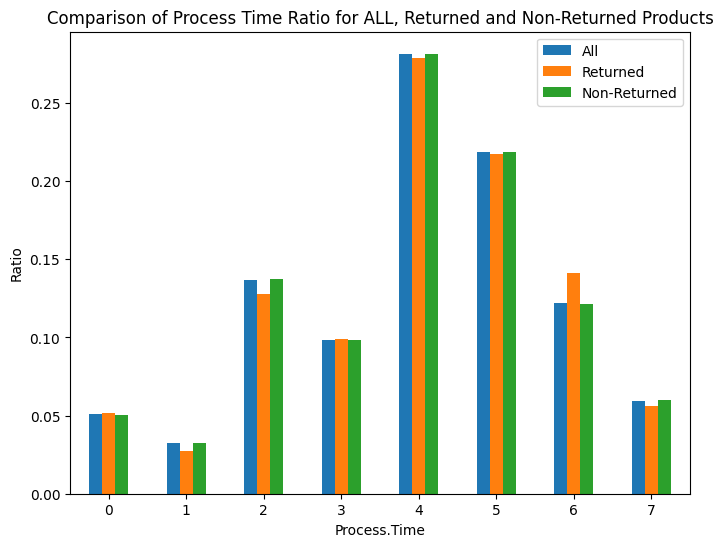

In [70]:
process_time_ratio.plot.bar(rot = 0, title = 'Comparison of Process Time Ratio \
for ALL, Returned and Non-Returned Products', ylabel = 'Ratio', figsize = (8, 6))

#### Count how many times a Product was Returned
If a product was returned before, it is likely that it might be returned again. We will count how many times a product was returned, if it never got returned we will impute the missing values using 0. Remember, more products ordered likely means more returns so we will use the ratio of returns.

In [85]:
# sum 0 means the products were never returned
product_returns_count = orders_merged.groupby(['Product.ID'])['Returned'].sum()
product_returns_count.sort_values()

Product.ID
TEC-PH-5833     0
TEC-PH-5834     0
TEC-PH-5837     0
TEC-PH-5822     0
TEC-PH-5823     0
               ..
OFF-ST-6031     6
OFF-AR-3499     6
OFF-ST-6251     6
OFF-ST-6033     9
OFF-FA-6129    12
Name: Returned, Length: 3788, dtype: int64

In [86]:
product_returns_ratio = orders_merged.groupby(['Product.ID'])['Returned'].mean()
product_returns_ratio.sort_values()

Product.ID
TEC-PH-5649    0.000000
FUR-BO-4859    0.000000
TEC-MA-4200    0.000000
TEC-MA-4202    0.000000
TEC-MA-5081    0.000000
                 ...   
FUR-BO-5810    0.666667
TEC-PH-3795    0.666667
FUR-BO-3644    1.000000
FUR-TA-3339    1.000000
OFF-PA-6525    1.000000
Name: Returned, Length: 3788, dtype: float64

In [87]:
# Lets insert columns product_returns_count and product_returns_ratio in the orders_merged dataframe
orders_merged['Product.ID.Return.Count'] = orders_merged['Product.ID'].map(lambda x: product_returns_count[x])
orders_merged['Product.ID.Return.Ratio'] = orders_merged['Product.ID'].map(lambda x: product_returns_ratio[x])

In [88]:
# lets look at the Product.ID and its return counts and ratio
orders_merged[['Product.ID', 'Product.ID.Return.Count', 'Product.ID.Return.Ratio']]

,Product.ID,Product.ID.Return.Count,Product.ID.Return.Ratio
0,TEC-PH-5816,0,0.000000
1,FUR-CH-5379,2,0.080000
2,TEC-PH-5356,2,0.083333
3,TEC-PH-5267,0,0.000000
4,TEC-CO-6011,0,0.000000
...,...,...,...
51285,OFF-FA-3072,1,0.055556
51286,FUR-FU-4070,0,0.000000
51287,OFF-AR-5321,0,0.000000
51288,OFF-BI-2919,2,0.055556


Returned
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: Product.ID.Return.Count, dtype: object

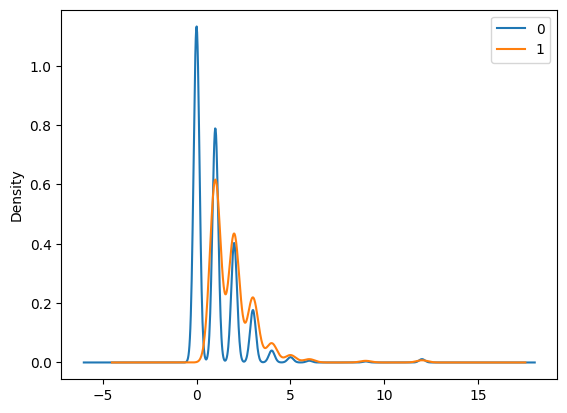

In [89]:
orders_merged.groupby('Returned')['Product.ID.Return.Count'].plot.kde(legend = True)

Returned
0    Axes(0.125,0.11;0.775x0.77)
1    Axes(0.125,0.11;0.775x0.77)
Name: Product.ID.Return.Ratio, dtype: object

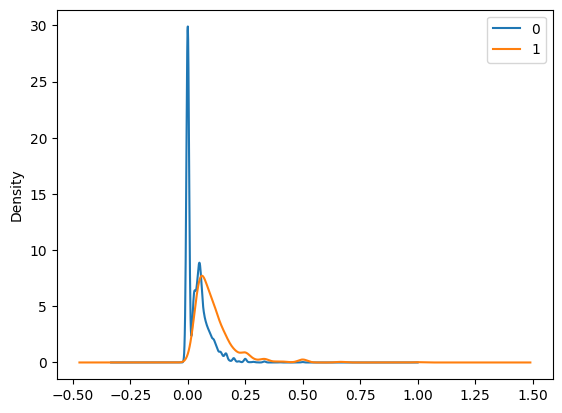

In [90]:
orders_merged.groupby('Returned')['Product.ID.Return.Ratio'].plot.kde(legend = True)

In [92]:
orders_merged[['Product.ID.Return.Ratio', 'Product.ID.Return.Count']].corr()

,Product.ID.Return.Ratio,Product.ID.Return.Count
Product.ID.Return.Ratio,1.000000,0.539588
Product.ID.Return.Count,0.539588,1.000000


We could create a new feature called profit_ratio = profit/sales. The idea is if profit margin is higher and customer finds similar product at a lower profit margin, they are likely to return.

## Fitting Models
- This is a binary classification problem: whether customer will return a product or not.
- Remove non-features like Customer.ID, Order.ID, Product.ID etc.
- Split data into train and test using 80:20 ratio
- Since the returned products is only 5% of total orders, use StratifiedKFold from sklearn while running cross-validation.

#### Model 0: Baseline

In [93]:
orders_merged['Returned'].value_counts(normalize = True)

Returned
0    0.956717
1    0.043283
Name: proportion, dtype: float64

### Model 1: Logistic Regression

In [94]:
orders_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51290 entries, 0 to 51289
Data columns (total 32 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Row.ID                   51290 non-null  int64         
 1   Order.ID                 51290 non-null  object        
 2   Order.Date               51290 non-null  datetime64[ns]
 3   Ship.Date                51290 non-null  datetime64[ns]
 4   Ship.Mode                51290 non-null  object        
 5   Customer.ID              51290 non-null  object        
 6   Customer.Name            51290 non-null  object        
 7   Segment                  51290 non-null  object        
 8   Postal.Code              9994 non-null   float64       
 9   City                     51290 non-null  object        
 10  State                    51290 non-null  object        
 11  Country                  51290 non-null  object        
 12  Region                   51290 n

In [95]:
sorted(orders_merged.columns)

['Category',
 'City',
 'Country',
 'Customer.ID',
 'Customer.Name',
 'Discount',
 'Market',
 'Order.Date',
 'Order.DayOfYear',
 'Order.ID',
 'Order.Month',
 'Order.Priority',
 'Order.WeekOfYear',
 'Order.Year',
 'Postal.Code',
 'Process.Time',
 'Product.ID',
 'Product.ID.Return.Count',
 'Product.ID.Return.Ratio',
 'Product.Name',
 'Profit',
 'Quantity',
 'Region',
 'Returned',
 'Row.ID',
 'Sales',
 'Segment',
 'Ship.Date',
 'Ship.Mode',
 'Shipping.Cost',
 'State',
 'Sub.Category']

In [98]:
# Note: Features not used that maybe could be useful: 'Region', 'Sub-Category', 'Order.Month', we are selecting features 
# that makes the most sense and keeping in mind the feature numbers vs data size as well
numeric_features = ['Discount', 'Process.Time', 'Product.ID.Return.Count', 'Product.ID.Return.Ratio', 'Profit', 'Quantity', 'Sales', 'Shipping.Cost']
categorical_features = ['Category', 'Market', 'Order.Priority', 'Segment', 'Ship.Mode']

features = numeric_features + categorical_features

print("Features used:", features)
print("Features not used: ", set(sorted(orders_merged.columns)) - set(features))

Features used: ['Discount', 'Process.Time', 'Product.ID.Return.Count', 'Product.ID.Return.Ratio', 'Profit', 'Quantity', 'Sales', 'Shipping.Cost', 'Category', 'Market', 'Order.Priority', 'Segment', 'Ship.Mode']
Features not used:  {'Customer.Name', 'Row.ID', 'Order.ID', 'Product.ID', 'Order.Date', 'Order.WeekOfYear', 'Sub.Category', 'State', 'City', 'Customer.ID', 'Order.Year', 'Country', 'Order.Month', 'Ship.Date', 'Postal.Code', 'Product.Name', 'Region', 'Order.DayOfYear', 'Returned'}


#### Dummify Categorical Variables and Drop the First Column in Each Category

In [101]:
# dummifies only categorical columns in the given data frame
X = pd.get_dummies(orders_merged[features], drop_first = True, dtype = 'int')

# the target is Returned
y = orders_merged['Returned']

In [104]:
X.shape

(51290, 22)

In [105]:
y.shape

(51290,)

In [110]:
X.sample(5)

,Discount,Process.Time,Product.ID.Return.Count,Product.ID.Return.Ratio,Profit,Quantity,Sales,Shipping.Cost,Category_Office Supplies,Category_Technology,Market_Asia Pacific,Market_Europe,Market_LATAM,Market_USCA,Order.Priority_High,Order.Priority_Low,Order.Priority_Medium,Segment_Corporate,Segment_Home Office,Ship.Mode_Same Day,Ship.Mode_Second Class,Ship.Mode_Standard Class
9321,0.17,4,0,0.000000,86.98,3,313.96,35.65,0,1,1,0,0,0,1,0,0,1,0,0,1,0
37090,0.70,5,3,0.157895,-36.81,2,20.43,2.98,1,0,0,0,0,0,1,0,0,0,0,0,0,1
18283,0.00,6,1,0.034483,52.86,1,182.37,14.55,0,0,0,0,0,0,0,0,1,1,0,0,0,1
43321,0.00,0,1,0.142857,601.97,7,1399.93,309.52,0,1,0,0,0,1,1,0,0,0,0,1,0,0
36936,0.10,7,0,0.000000,22.24,2,87.16,3.03,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [109]:
y.sample(5)

50396    0
44940    0
6293     0
28042    0
6052     0
Name: Returned, dtype: int64

#### Split the data into train and test set

In [111]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0, stratify = y)

In [112]:
X_train.shape

(41032, 22)

In [113]:
X_test.shape

(10258, 22)

In [114]:
y_train.shape

(41032,)

In [115]:
y_test.shape

(10258,)

### Fit Logistic Regression Model

In [116]:
# Use balanced_weight for imbalanced dataclass
logit = LogisticRegression(class_weight = 'balanced', max_iter = 100000)
logit.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', max_iter=100000)

### Evaluating Logistic Regression Model

In [117]:
# predict on test data
y_pred = logit.predict(X_test)

In [140]:
# confusion matrix, be careful with normalize option (we want normalize = 'true')
contingenycy_table = confusion_matrix(y_test, y_pred, normalize = 'all')
contingenycy_table

array([[0.71573406, 0.24098265],
       [0.01208813, 0.03119516]])

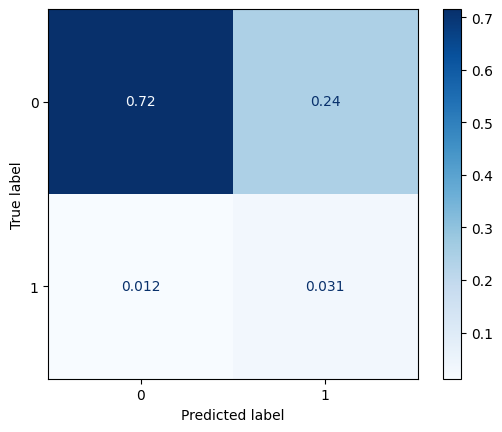

In [141]:
# Display Confusion Matrix
display = ConfusionMatrixDisplay(contingenycy_table, display_labels= logit.classes_)
display.plot(cmap=plt.cm.Blues)

## Confusion Matrix Interpretation

In this confusion matrix, class 0 represents non-returned items and class 1 represents returned items.

|                | Predicted: Non-Returned | Predicted: Returned |
|----------------|-------------------------|---------------------|
| **Actual: Non-Returned** | 0.72 (True Negative)       | 0.24 (False Positive)  |
| **Actual: Returned**     | 0.012 (False Negative)     | 0.031 (True Positive)  |

### Key Points:
- **True Negatives (TN)**: 0.72
  - 72% of non-returned items were correctly predicted as non-returned.
- **False Positives (FP)**: 0.24
  - 24% of non-returned items were incorrectly predicted as returned.
- **False Negatives (FN)**: 0.012
  - 1.2% of returned items were incorrectly predicted as non-returned.
- **True Positives (TP)**: 0.031
  - 3.1% of returned items were correctly predicted as returned.

### Summary:
- This confusion matrix suggests that the model is more effective at identifying non-returned items than returned items.


The robust matrix for classification for imbalanced classes is **ROUC-AUC** score and **F1-Score**.

In [144]:
# weighted avg is the most significant for the imbalanced data sets
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.75      0.85      9814
           1       0.11      0.72      0.20       444

    accuracy                           0.75     10258
   macro avg       0.55      0.73      0.52     10258
weighted avg       0.95      0.75      0.82     10258



#### ROC-AUC Curve

In [167]:
# print auc score, y_pred is using 0.5 threshold
print(roc_auc_score(y_test, y_pred))

0.7344178292823085


In [168]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, logit.predict_proba(X_test)[:, 1])

In [169]:
# Predict probabilities
y_prob = logit.predict_proba(X_test)[:, 1]

# Calculate AUC using all distinct probabilities value in y_prob
roc_auc = roc_auc_score(y_test, y_prob)
print(f'AUC: {roc_auc:.2f}')

AUC: 0.82


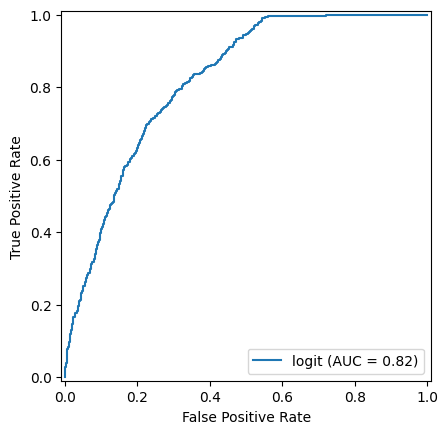

In [170]:
# Display ROC curve using the optimal roc_auc score using all possible probability threshold
roc_display = RocCurveDisplay(fpr = fpr, tpr = tpr, roc_auc = roc_auc, estimator_name='logit')
roc_display.plot()

plt.show()

### Model 2: Random Forest Classifier

In [172]:
rf = RandomForestClassifier(class_weight = 'balanced', n_jobs = -1, max_depth = 7)
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=7, n_jobs=-1)

In [173]:
y_pred = rf.predict(X_test)

In [174]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.56      0.71      9814
           1       0.08      0.91      0.16       444

    accuracy                           0.57     10258
   macro avg       0.54      0.73      0.43     10258
weighted avg       0.95      0.57      0.69     10258



In [176]:
# uses probability threshold as 0.5
roc_auc_score(y_test, y_pred)

np.float64(0.7323085516737442)

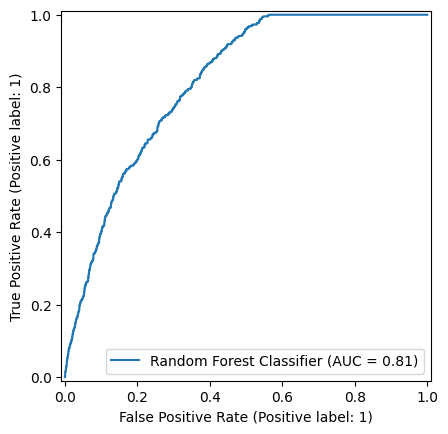

In [179]:
# Display ROC curve using from_estimator, note the auc is different than using roc_auc_score(y_test, y_pred)
roc_display = RocCurveDisplay.from_estimator(rf, X_test, y_test, name = 'Random Forest Classifier')


### Evaluating Models

- **What is the best metric to evaluate your model if the data is strongly imbalanced?**
    - Accuracy is not a good metric because the data is strongly imbalanced.
    - The ROC AUC is a good (general) metric in this case because it is robust to the class imbalance.

- **Now we have multiple models, which one would you pick?**
    - Generally, the one with the best ROC AUC.

- **Can we get any clue from the confusion matrix? What is the meaning of precision and recall in this case? Which one do you care the most? How will our model help the stakeholder make decisions?**
    - It really depends on your understanding of the business model.
    - For example, if I find a product that has a high probability of being returned, I would recommend my stakeholder to put it on final sale so the customer gets it for a lower price but they are not allowed to return the product.
    - However, if the product turns out to be just fine and we are losing profit because we give it a discount, in that case, I would prefer a model that has relatively good accuracy with better precision (lower Type 1 error / False Positives).


### Feature Engineering Revisit


- The `Product.ID.Return.Count` (and `Product.ID.Return.Ratio`) feature was wrong. If we want to use the training dataset to fit a model and the test dataset to test a model, we assume the test dataset is new data we get after fitting the model. But using the whole dataset to count the times will actually indicate these items will be returned in the test dataset. That's why the process is invalid.
- The easiest way to fix the problem is to split the train and test set by different timespans. You can use 2012-2014 data for training and 2015 data for testing. It will mimic the same scenario in real life: you don't know what's going to happen in the future. :)
- A great blog post from fastai discusses this problem.


In [180]:
orders_merged['Order.Year'].value_counts()

Order.Year
2015    17531
2014    13799
2013    10962
2012     8998
Name: count, dtype: int64